# Text Classification: Sentiment Analysys with BERT using Hugging Face and Pytorch and Python

### Reference:
Author: Venelin Valkov

* [Article](https://curiousily.com/posts/sentiment-analysis-with-bert-and-hugging-face-using-pytorch-and-python/)

* [Video](https://www.youtube.com/watch?v=8N-nM3QW7O0&t=865s)

* [Google Colab](https://colab.research.google.com/drive/1PHv-IRLPCtv7oTcIGbsgZHqrB5LPvB7S#scrollTo=SgPRhuMzi9ot)

## Setup

Before start, change execution environment to GPU.

In [1]:
!nvidia-smi

Sat Mar 13 20:05:02 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.56       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   67C    P8    11W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

Install Transformers library by Hugging Face

In [2]:
!pip install -q -U watermark
!pip install -qq transformers

     |████████████████████████████████| 1.9MB 8.5MB/s 
     |████████████████████████████████| 3.2MB 47.8MB/s 
     |████████████████████████████████| 890kB 50.9MB/s 


In [3]:
%reload_ext watermark
%watermark -v -p numpy,pandas,torch,transformers

Python implementation: CPython
Python version       : 3.7.10
IPython version      : 5.5.0

numpy       : 1.19.5
pandas      : 1.1.5
torch       : 1.8.0+cu101
transformers: 4.3.3



Run required imports and do some basic settings to matplotlib plotting colors and torch device

In [4]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import torch
import torch.nn.functional as F
import transformers

from collections import defaultdict
from matplotlib import rc
from pylab import rcParams
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split
from textwrap import wrap
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader
from transformers import BertModel, BertTokenizer, AdamW, get_linear_schedule_with_warmup


%matplotlib inline
%config InlineBackend.figure_format='retina'

sns.set(style='whitegrid', palette='muted', font_scale=1.2)

HAPPY_COLORS_PALETTE = ["#01BEFE", "#FFDD00", "#FF7D00", "#FF006D", "#ADFF02", "#8F00FF"]

sns.set_palette(sns.color_palette(HAPPY_COLORS_PALETTE))

rcParams['figure.figsize'] = 12, 8

RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

## Data Exploration

Load the Google Play app reviews dataset that the author provided in his GDrive and I copied to my repository to guarantee I'll always have these data.

In [5]:
# !gdown --id 1S6qMioqPJjyBLpLVz4gmRTnJHnjitnuV
# !gdown --id 1zdmewp7ayS4js4VtrJEHzAheSW-5NBZv
reviews_csv = "https://github.com/GabrielNP/sentiment_analysis_studies/blob/main/data/reviews.csv?raw=true"
apps_csv = "https://github.com/GabrielNP/sentiment_analysis_studies/raw/main/data/apps.csv"

Two (apps and reviews) .csv files were downloaded.

Now it's time to analyse them.

In [ ]:
df = pd.read_csv("https://github.com/GabrielNP/sentiment_analysis_studies/blob/main/data/reviews.csv?raw=true")
df.head()

In [ ]:
df.shape

We have almost 16K reviews.

Let's check for missing values:

In [ ]:
df.info()

All of them are non-null. Great!

Let visualize in chat the data:

In [ ]:
sns.countplot(df.score)
plt.xlabel('review score');

As we can see, the data are imbalanced.

We're gonna balance them by converting into negative, positive and neutral sentiments.

In [10]:
def to_sentiment(rating):
  rating = int(rating)
  if rating <= 2:
    return 0
  elif rating == 3:
    return 1
  else: 
    return 2

df['sentiment'] = df.score.apply(to_sentiment)

In [11]:
class_names = ['negative', 'neutral', 'positive']

In [ ]:
ax = sns.countplot(df.sentiment)
plt.xlabel('review sentiment')
ax.set_xticklabels(class_names);

Now we have them balanced.

## Data preprocessing

Machine Learning models don't work with raw text. We need to convert text to numbers.

Furthermore BERT requests to:


*   Add special tokens to separate sentences and do classification
*   Pass sequences of constant length (introduce padding)
*   Create array of 0s (pad token) and 1s (real token) called attention mask

*The Transformers library provides a wide variety of Transformer models (including BERT). It works with TensorFlow and PyTorch! It also includes prebuild tokenizers that do the heavy lifting for us!*

Declare pre-trained model name constant:

In [13]:
PRE_TRAINED_MODEL_NAME = 'bert-base-cased'

In case of sentiment analysis make more sense we use case sensitive classification.

Load pre-trained BERT tokenizer model:

In [14]:
tokenizer = BertTokenizer.from_pretrained(PRE_TRAINED_MODEL_NAME)

Take the following text to understand tokenization process:

In [15]:
sample_txt = 'When was I last outside? I am stuck at home for 2 weeks.'

Some basic operations can convert text to tokens and tokens to unique integers (ids):

In [16]:
tokens = tokenizer.tokenize(sample_txt)
token_ids = tokenizer.convert_tokens_to_ids(tokens)

print(f' Sentence: {sample_txt}')
print(f'   Tokens: {tokens}')
print(f'Token IDs: {token_ids}')

 Sentence: When was I last outside? I am stuck at home for 2 weeks.
   Tokens: ['When', 'was', 'I', 'last', 'outside', '?', 'I', 'am', 'stuck', 'at', 'home', 'for', '2', 'weeks', '.']
Token IDs: [1332, 1108, 146, 1314, 1796, 136, 146, 1821, 5342, 1120, 1313, 1111, 123, 2277, 119]


Now we've tokenized our sample text. But we still need to add these some special tokens:

* [SEP] - marker for ending of a sentence

* [CLS] - we must add this token to the start of each sentence, so BERT knows we're doing classification

* [PAD] - padding

* [UNK] - unknown, everything else BERT didn't understood


There are unique integers to these tokens. See:

In [17]:
print(tokenizer.sep_token, tokenizer.sep_token_id)
print(tokenizer.cls_token, tokenizer.cls_token_id)
print(tokenizer.pad_token, tokenizer.pad_token_id)
print(tokenizer.unk_token, tokenizer.unk_token_id)

[SEP] 102
[CLS] 101
[PAD] 0
[UNK] 100


Let's add these special tokens to sample text:

In [18]:
encoding = tokenizer.encode_plus(
    sample_txt,
    max_length=32,
    add_special_tokens=True,
    return_token_type_ids=False,
    pad_to_max_length=True,
    return_attention_mask=True,
    return_tensors='pt' #pt = Pytorch Tensors
)

encoding

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2155: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


{'input_ids': tensor([[ 101, 1332, 1108,  146, 1314, 1796,  136,  146, 1821, 5342, 1120, 1313,
         1111,  123, 2277,  119,  102,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0]])}

Notice that we have the same sequence of sample text token ids above, but with the special tokens added.

Also token ids and attention mask are now stored in a Tensor and padded to a length of 32. See:

In [19]:
print(len(encoding['input_ids'][0]))
encoding['input_ids'][0]

32


tensor([ 101, 1332, 1108,  146, 1314, 1796,  136,  146, 1821, 5342, 1120, 1313,
        1111,  123, 2277,  119,  102,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0])

In [20]:
print(len(encoding['attention_mask'][0]))
encoding['attention_mask']

32


tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0]])

It's possible to inverse tokenization from ids to tokens back:

In [ ]:
tokenizer.convert_ids_to_tokens(encoding['input_ids'][0])

Now is clear to see the tokenized sample text with the special tokens added.

We've hard-coded 32 as max length above, because BERT works better with fixed-length sequences. 32 is more than enough to that sample text and that's why tokenization process ended with a lot of 0s ids (or PAD tokens).

In real cases there is a strategy to set the max length.

**Let's get back to loaded reviews data:**

In [ ]:
df.content

Store the token length of each review:

In [23]:
token_lens = []

for txt in df.content:
  tokens = tokenizer.encode(txt, max_length=512)
  token_lens.append(len(tokens))

Plot the distribution:

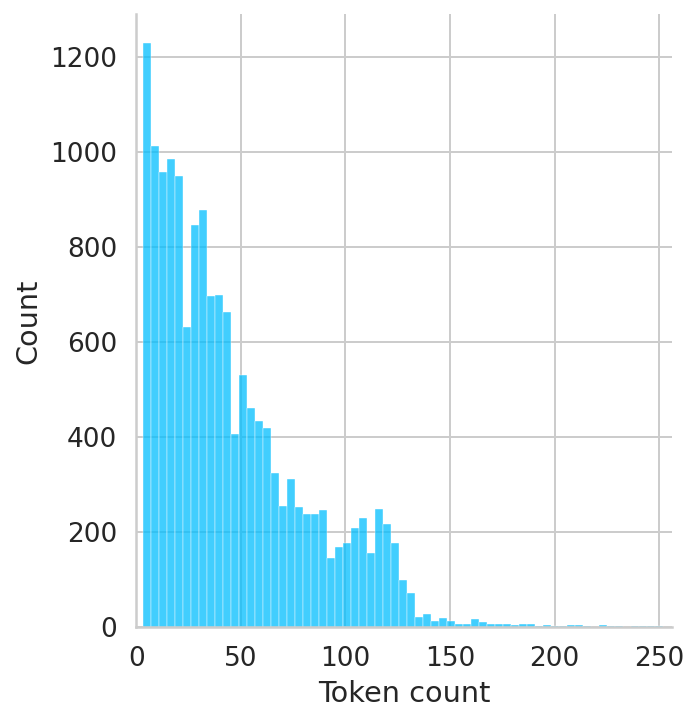

In [24]:
sns.displot(token_lens)
plt.xlim([0, 256]);
plt.xlabel('Token count');

Most of the reviews seem to contain less than 128 tokens, but we'll be on the safe side and choose a maximum length of 160:

In [25]:
MAX_LEN = 160

Declare a class that runs the tokenization process and returns review texts:

In [26]:
class GPReviewDataset(Dataset):

  def __init__(self, reviews, targets, tokenizer, max_len):
    self.reviews = reviews
    self.targets = targets
    self.tokenizer = tokenizer
    self.max_len = max_len
  
  def __len__(self):
    return len(self.reviews)
  
  def __getitem__(self, item):
    review = str(self.reviews[item])
    target = self.targets[item]

    encoding = self.tokenizer.encode_plus(
      review,
      add_special_tokens=True,
      max_length=self.max_len,
      return_token_type_ids=False,
      pad_to_max_length=True,
      return_attention_mask=True,
      return_tensors='pt',
    )

    return {
      'review_text': review,
      'input_ids': encoding['input_ids'].flatten(),
      'attention_mask': encoding['attention_mask'].flatten(),
      'targets': torch.tensor(target, dtype=torch.long)
    }

Split the data into train, test and evaluation parts:

In [27]:
df_train, df_test = train_test_split(df, test_size=0.1, random_state=RANDOM_SEED)
df_val, df_test = train_test_split(df_test, test_size=0.5, random_state=RANDOM_SEED)
df_train.shape, df_val.shape, df_test.shape

((14171, 12), (787, 12), (788, 12))

Create Data Loader for each part above that will reference GPReviewDataset class:

In [28]:
def create_data_loader(df, tokenizer, max_len, batch_size):
  ds = GPReviewDataset(
    reviews=df.content.to_numpy(),
    targets=df.sentiment.to_numpy(),
    tokenizer=tokenizer,
    max_len=max_len
  )

  return DataLoader(
    ds,
    batch_size=batch_size,
    num_workers=4
  )

In [ ]:
BATCH_SIZE = 16

train_data_loader = create_data_loader(df_train, tokenizer, MAX_LEN, BATCH_SIZE)
val_data_loader = create_data_loader(df_val, tokenizer, MAX_LEN, BATCH_SIZE)
test_data_loader = create_data_loader(df_test, tokenizer, MAX_LEN, BATCH_SIZE)

In [ ]:
data = next(iter(train_data_loader))
data

In [ ]:
data.keys()

In [ ]:
print(data['input_ids'].shape)
print(data['attention_mask'].shape)
print(data['targets'].shape)

## Sentiment Classification with BERT and Hugging Face

Load the model:

In [ ]:
bert_model = BertModel.from_pretrained(PRE_TRAINED_MODEL_NAME)

 Try to use it on the encoding of our sample text:

In [34]:
b = bert_model(
  input_ids=encoding['input_ids'], 
  attention_mask=encoding['attention_mask']
)
last_hidden_state = b[0]
pooled_output = b[1]
del b

In [ ]:
print(last_hidden_state)
print(pooled_output)

* the last_hidden_state is a sequence of hidden states of the last layer of the model

In [ ]:
last_hidden_state.shape

* 768 is the number of hidden units in the feedforward-networks. 

We can verify that by checking the config:

In [ ]:
bert_model.config.hidden_size

* pooled_output is as a summary of the content, according to BERT

Let's look at the shape of the output:

In [ ]:
pooled_output.shape

We can use all of this knowledge to create a classifier that uses the BERT model:

In [77]:
class SentimentClassifier(nn.Module):

  def __init__(self, n_classes, input_ids, attention_mask):
    super(SentimentClassifier, self).__init__()
    self.bert = BertModel.from_pretrained(PRE_TRAINED_MODEL_NAME)
    self.drop = nn.Dropout(p=0.3)
    self.out = nn.Linear(self.bert.config.hidden_size, n_classes)
    self.input_ids = input_ids
    self.attention_mask = attention_mask
  
  def forward(self):
    a, pooled_output = self.bert(
      input_ids=input_ids,
      attention_mask=attention_mask
    )
    print(a)
    output = self.drop(pooled_output)
    return self.out(output)

* our classifier delegates most of the heavy lifting to the BertModel

* we use a dropout layer for some regularization and a fully-connected layer 
for our output

* note that we're returning the raw output of the last layer since that is required for the cross-entropy loss function in PyTorch to work


Move the example batch of our training data to the GPU:

In [ ]:
input_ids = data['input_ids'].to(device)
attention_mask = data['attention_mask'].to(device)

print(input_ids.shape) # batch size x seq length
print(attention_mask.shape) # batch size x seq length

Let's create an instance and move it to the GPU:

In [79]:
model = SentimentClassifier(len(class_names), input_ids, attention_mask)
model = model.to(device)

Apply the softmax function to the outputs to get the predicted probabilities from our trained model:

In [ ]:
model.forward()
F.softmax(model(input_ids, attention_mask), dim=1)